In [ ]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.utils.data import TensorDataset
from torch.utils.data import ConcatDataset

In [ ]:
#Convert the dataset into Tensor used by PyTorch
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the MINST data directly from PyTorch
#The downloaded datasets are stored in the same folder with this jupyter notebook file
#For train dataset, use "train=True"
#For test dataset, use "train=False"
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

#Load the datasets into DataLoader
train_dataloader_total = DataLoader(train_dataset, batch_size=1000, shuffle=False, num_workers=0)
test_dataloader_total = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=0)

class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']


#Only use 1000 training samples and 1000 test samples
train_dataiter = iter(train_dataloader_total)
test_dataiter = iter(test_dataloader_total)
train_samples = next(train_dataiter)
test_samples = next(test_dataiter)

train_dataset_1000 = TensorDataset(train_samples[0], train_samples[1])
test_dataset_1000 = TensorDataset(test_samples[0], test_samples[1])

#Load the 1000 datasets into DataLoader
train_dataloader = DataLoader(train_dataset_1000, batch_size=64, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset_1000, batch_size=64, shuffle=False, num_workers=0)

In [ ]:

#dataiter = iter(test_dataloader)
# Try to generate more poisoned samples.
dataiter = iter(test_dataloader_total)
first_batch = next(dataiter)
first_batch_instances = first_batch[0]
first_batch_labels = first_batch[1]

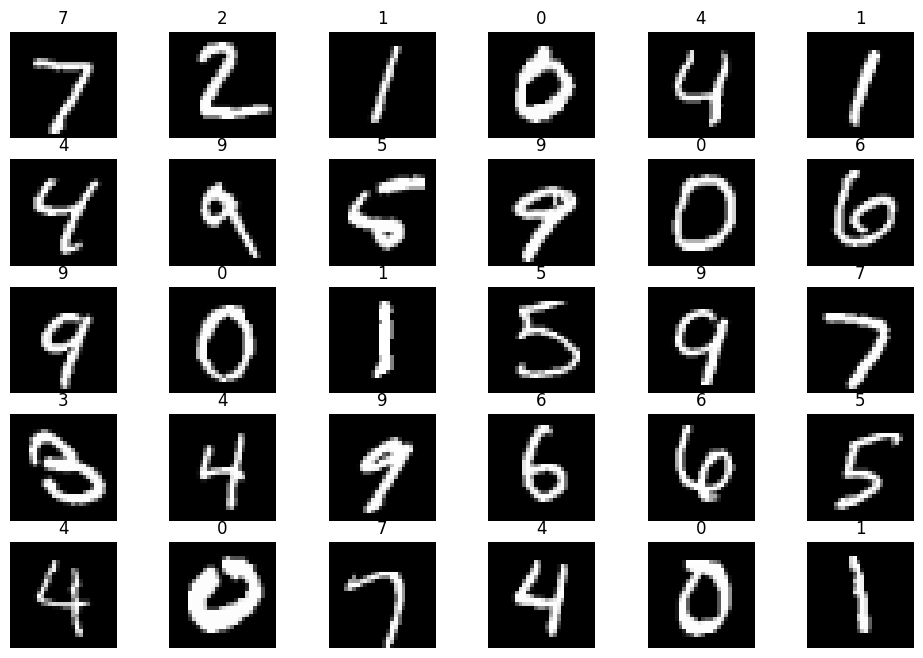

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plot the data
def plot_digits(instances, labels, images_per_row):
  for i in range(len(instances)):
      idx = i // images_per_row
      idy = i % images_per_row 
      ax[idx, idy].imshow(instances[i].squeeze(), cmap="gray")
      ax[idx, idy].set_title(class_names[labels[i]])
      ax[idx, idy].axis("off")

#plot the first rows * columns from the first batch in a rows-columns grid. 
nrows = 5
ncolumns = 6

fig, ax = plt.subplots(nrows, ncolumns, figsize=(12, 8))
example_images = first_batch[0][:nrows*ncolumns]
example_labels = first_batch[1][:nrows*ncolumns]
plot_digits(example_images, example_labels, images_per_row=ncolumns)
plt.show()

In [ ]:
torch.manual_seed(42)

class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #1 input channel to 10 channels 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)#10 channels to 20 channels
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   #Use ReLU as activation function -> 64 * 10 * 24 * 24
        x = F.max_pool2d(x, 2)      #Apply max_pooling on the output of the convolution layer -> 64 * 10 * 12 * 12
        x = F.relu(self.conv2(x))   # -> 64 * 20 * 8 * 8
        x = F.max_pool2d(x, 2)      # 64 * 20 * 4 * 4
        x = torch.flatten(x, -3)     # 64 * 320, here using torch.flatten(x, -3) makes the model more generic compared to using torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
epochs = 5
lr = 0.01
criterion = nn.CrossEntropyLoss()
model = ClassificationNet()
optimizer = optim.Adam(model.parameters(), lr = lr)
print(model)

ClassificationNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
model.train()
for ep in range(epochs):
  running_loss = 0
  train_total = 0.0
  train_correct = 0.0
  y_train, y_predict = [], []

  for batch, (X, y) in enumerate(train_dataloader):
    optimizer.zero_grad()
    y_predict = model(X)
    loss = criterion(y_predict, y)
    loss.backward()
    optimizer.step()


    _, y_predict = torch.max(y_predict, dim=1)
    running_loss = running_loss + loss.item()
    train_total = train_total + X.shape[0]
    train_correct = train_correct + (y_predict == y).sum().item()

  print("epoch [%d] loss [%f] accuracy [%f]" % (ep, running_loss, train_correct/train_total))

epoch [0] loss [25.508003] accuracy [0.491000]
epoch [1] loss [9.211568] accuracy [0.802000]
epoch [2] loss [5.196942] accuracy [0.903000]
epoch [3] loss [2.667832] accuracy [0.949000]
epoch [4] loss [2.034101] accuracy [0.956000]


In [ ]:
model.eval()

running_loss = 0
train_total = 0.0
train_correct = 0.0
y_train, y_predict = [], []

with torch.no_grad():
  for batch, (X, y) in enumerate(test_dataloader):
    y_predict = model(X)
    loss = criterion(y_predict, y)
    _, y_predict = torch.max(y_predict, dim=1)
    running_loss = running_loss + loss.item()
    train_total = train_total + X.shape[0]
    train_correct = train_correct + (y_predict == y).sum().item()
  print("Testing: loss [%f] accuracy [%f]" % (running_loss, train_correct/train_total))

Testing: loss [4.336395] accuracy [0.908000]


In [ ]:
target_label_name = '5'
base_label_name = '4'
target_label_index = class_names.index(target_label_name)
base_label_index = class_names.index(base_label_name)

print("The target index is %d " % (target_label_index))
print("The base index is %d " % (base_label_index))



all_target_instances = first_batch_instances[first_batch_labels == target_label_index]
all_base_instances = first_batch_instances[first_batch_labels == base_label_index]

# we only keep up to 20 target instances and 20 base instances to generate poisoned samples. 

num_target_instances = 20 if 20 < all_target_instances.shape[0] else all_target_instances.shape[0]
num_base_instances = 20 if 20 < all_base_instances.shape[0] else all_base_instances.shape[0]

all_target_instances = all_target_instances[: num_target_instances]
all_base_instances = all_base_instances[: num_base_instances]


print("There are totally %d target instances." % (all_target_instances.shape[0]))
print("There are totally %d base instances." % (all_base_instances.shape[0]))

one_target_instance = all_target_instances[0]

print(one_target_instance.shape)

with torch.no_grad():
  predict_labels = model(all_target_instances)
  #predict_label = predict_label.reshape(-1, predict_label.shape[0])
  _, predict_labels = torch.max(predict_labels, dim = 1)
  print(predict_labels)

with torch.no_grad():
  predict_labels = model(all_base_instances)
  _, predict_labels = torch.max(predict_labels, dim = 1)
  print(predict_labels)





The target index is 5 
The base index is 4 
There are totally 20 target instances.
There are totally 20 base instances.
torch.Size([1, 28, 28])
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4])


In [ ]:
torch.manual_seed(247)

# put the model into the inference mode
for p in model.parameters():
  p.requires_grad = False


layer_outputs = {}

def get_activation(layer_name):
        def hook(module, input, output):
            layer_outputs[layer_name] = output
        return hook

fc1_output_hook = model.fc1.register_forward_hook(get_activation("fc1"))



We have generated 359 qualified poisoned examples.


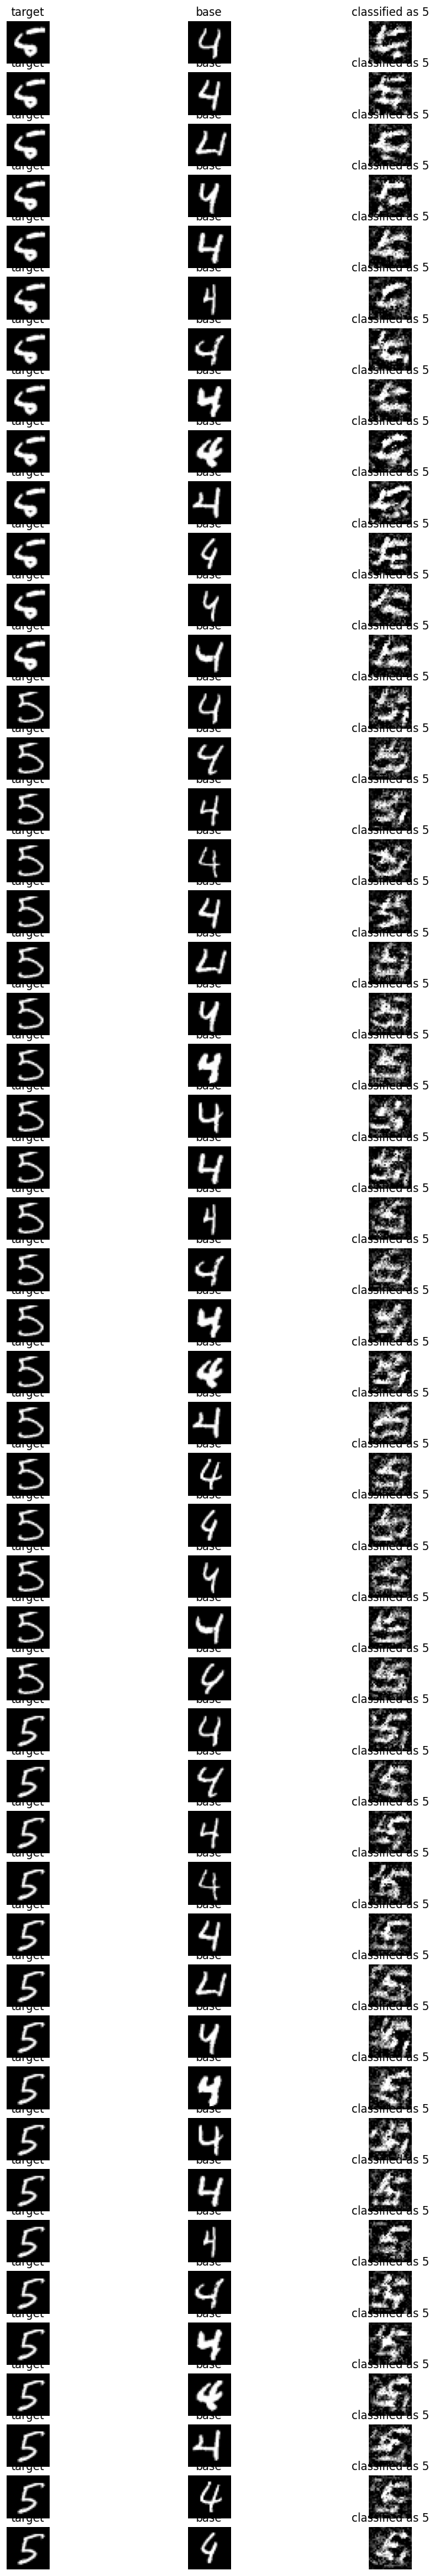

In [ ]:
def gen_one_poisoned_sample(one_base_instance, one_target_instance, model, beta):
  # It is worth noting that this model is ready for the inference mode and it has already been hooked. 

  output_target = model(one_target_instance)
  fc1_target = layer_outputs['fc1']

  x = torch.rand_like(one_base_instance, requires_grad=True)
  x = torch.nn.parameter.Parameter(x, requires_grad=True)

  lr = 0.01
  optimizer = torch.optim.Adam([x], lr=lr)
  epochs = 100

  for i in range(epochs):
    output_x = model(torch.clamp(x, 0, 1))
    fc1_x = layer_outputs['fc1']
    loss = torch.linalg.norm(fc1_x - fc1_target) + beta * torch.linalg.norm(x - one_base_instance)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  x = torch.clamp(x, 0, 1).detach()

  with torch.no_grad():
    predict_label = model(x)
    predict_label = predict_label.reshape(-1, predict_label.shape[0])
    _, predict_label = torch.max(predict_label, dim = 1)


  return x, predict_label.item()

target_temp = []
base_temp = []

generated_X = []
generated_X_labels = []


for i in all_target_instances:
  for j in all_base_instances:
    one_poisoned_sample, label = gen_one_poisoned_sample(j, i, model, 0.8)
    if label == target_label_index:
      # it is possible that the label does not meet our need. In this case, we discard this poisoned example. 
      target_temp.append(i)
      base_temp.append(j)
      generated_X.append(one_poisoned_sample)
      generated_X_labels.append(label)

print("We have generated %d qualified poisoned examples." % (len(generated_X)))


num = 50 if 50 < len(generated_X) else len(generated_X)

fig, ax = plt.subplots(num, 3, figsize=(10, 50))

for idx in range(num):
  ax[idx, 0].imshow(target_temp[idx].squeeze(), cmap="gray")
  ax[idx, 0].set_title("target")
  ax[idx, 0].axis("off")


  ax[idx, 1].imshow(base_temp[idx].squeeze(), cmap="gray")
  ax[idx, 1].set_title("base")
  ax[idx, 1].axis("off")

  ax[idx, 2].imshow(generated_X[idx].squeeze(), cmap="gray")
  ax[idx, 2].set_title("classified as %d" % (generated_X_labels[idx]))
  ax[idx, 2].axis("off")

plt.show()


In [ ]:
generated_X = torch.stack(generated_X)


with torch.no_grad():
  predict = model(generated_X)
  _ , generated_X_labels = torch.max(predict, dim=1)

# Here are the original labels of poisoned samples.
print(generated_X.shape)
print(generated_X_labels)

# change the label of poisoned samples into the base index.
temp = [base_label_index for i in generated_X_labels]
generated_X_labels = torch.IntTensor(temp)
print(generated_X_labels)

TypeError: ignored

In [ ]:
#Construct poisoned dataset with the base label
poisoned_dataset = TensorDataset(generated_X, generated_X_labels)


#Concatenate the original train_dataset and the poisoned dataset to new_train_dataset 
poisoned_train_dataset = ConcatDataset([poisoned_dataset, train_dataset_1000])

#Load the datasets into DataLoader
poisoned_train_dataloader = DataLoader(poisoned_train_dataset, batch_size=64, shuffle=False, num_workers=0)

epochs = 5
learning_rate = 0.01
weight_decay = 5e-4
criterion = nn.CrossEntropyLoss()

#Instantialize a new model
poisoned_model = ClassificationNet()
poisoned_optimizer = optim.Adam(poisoned_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

#Retrain the model
for ep in range(epochs):
  running_loss = 0
  train_total = 0.0
  train_correct = 0.0
  y_train, y_predict = [], []

  for batch, (X, y) in enumerate(poisoned_train_dataloader):
    poisoned_optimizer.zero_grad()
    y_predict = poisoned_model(X)
    loss = criterion(y_predict, y)
    loss.backward()
    poisoned_optimizer.step()


    _, y_predict = torch.max(y_predict, dim=1)
    running_loss = running_loss + loss.item()
    train_total = train_total + X.shape[0]
    train_correct = train_correct + (y_predict == y).sum().item()

  print("epoch [%d] loss [%f] accuracy [%f]" % (ep, running_loss, train_correct/train_total))



RuntimeError: ignored

In [ ]:
with torch.no_grad():
  predict_label = poisoned_model(all_target_instances)
  _, predict_label = torch.max(predict_label, 1)
  print("The target label is: ", target_label_index)
  print("The predicted target label is:", predict_label)

The target label is:  5
The predicted target label is: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])
